In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [1]:
%%capture output
!unzip Model.zip

In [2]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series, plot_joint_angle_from_sto_file as pja, plot_act_length_from_sto_file as pal
from neural_simulations import run_neural_simulations, run_flexor_extensor_neuron_simulation
from activation import decode_spikes_to_activation


Start Simulation with the followinf EES :
EES frequency : 50. Hz
Number Ia fibers recruited : 60 / 60
Number II fibers recruited : 60 / 60
Number Efferent fibers recruited : 0 / 169
--- Iteration 1 of 10 ---
--- Iteration 2 of 10 ---
--- Iteration 3 of 10 ---
--- Iteration 4 of 10 ---
--- Iteration 5 of 10 ---
--- Iteration 6 of 10 ---
--- Iteration 7 of 10 ---
--- Iteration 8 of 10 ---
--- Iteration 9 of 10 ---
--- Iteration 10 of 10 ---
Saved: results/Spikes_Ia_60_II_60eff_0_freq_50. Hz.json


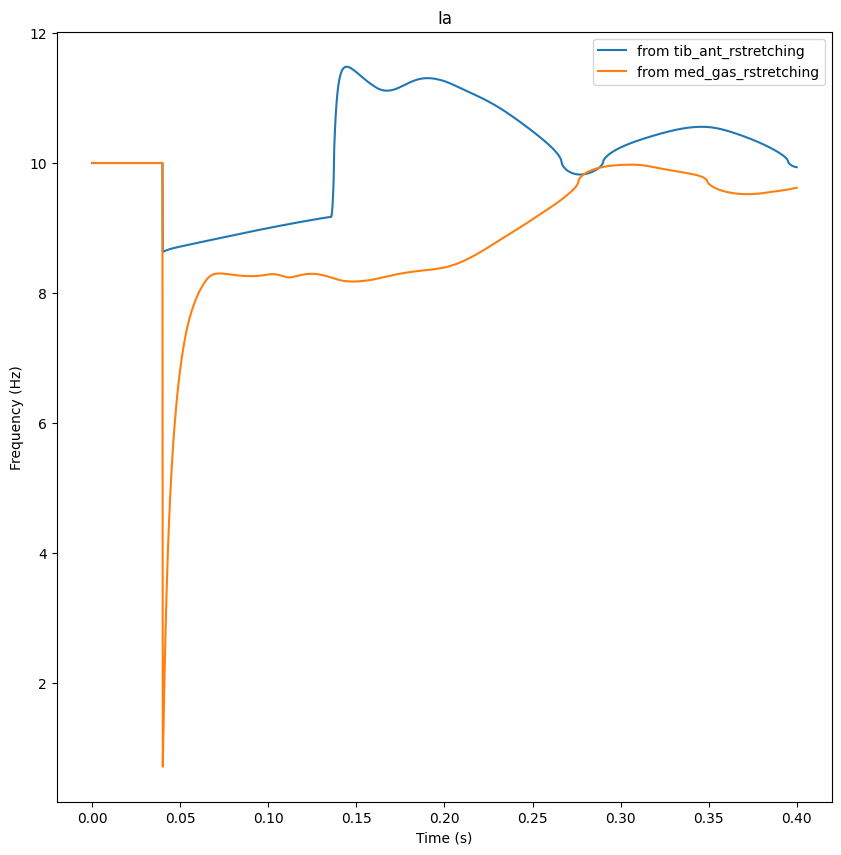

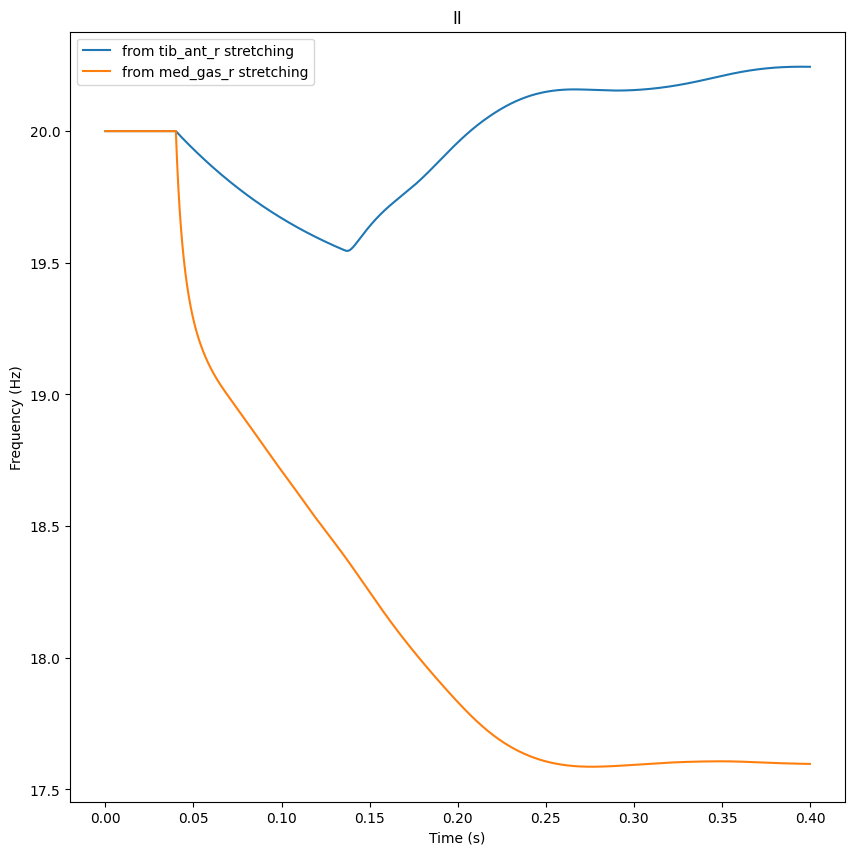

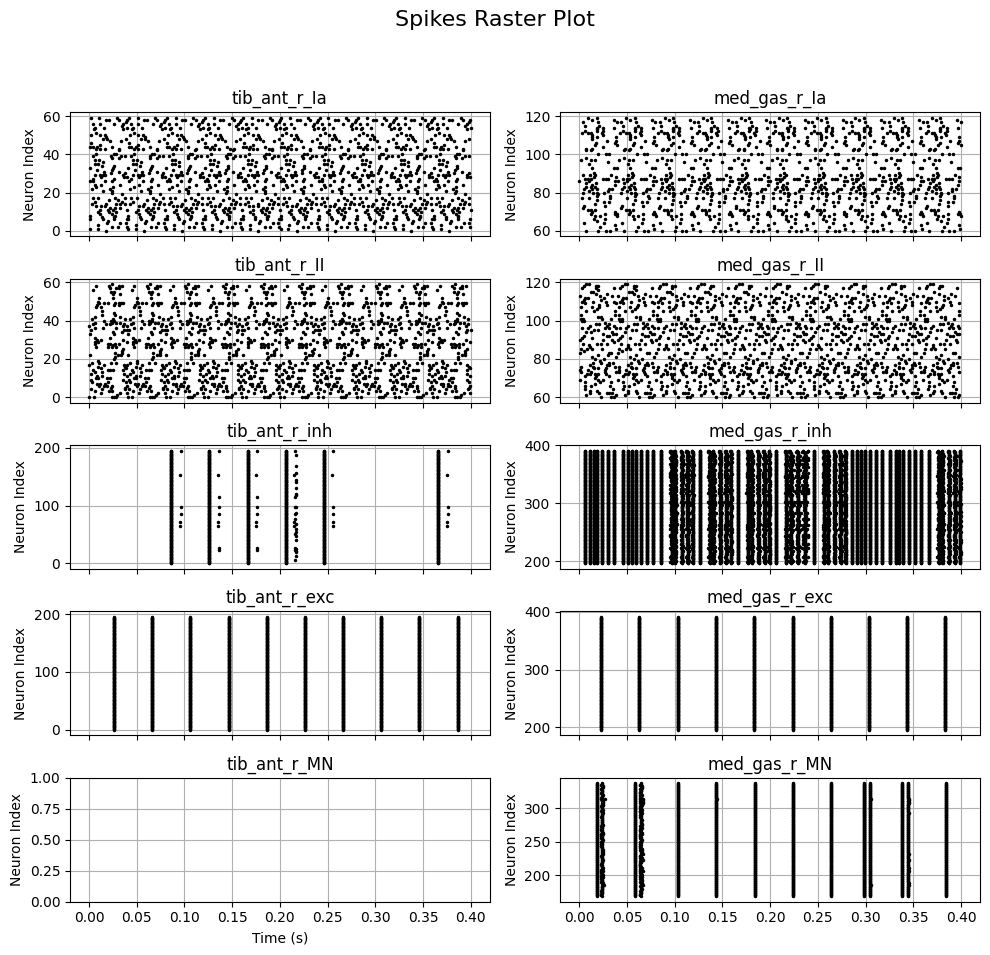

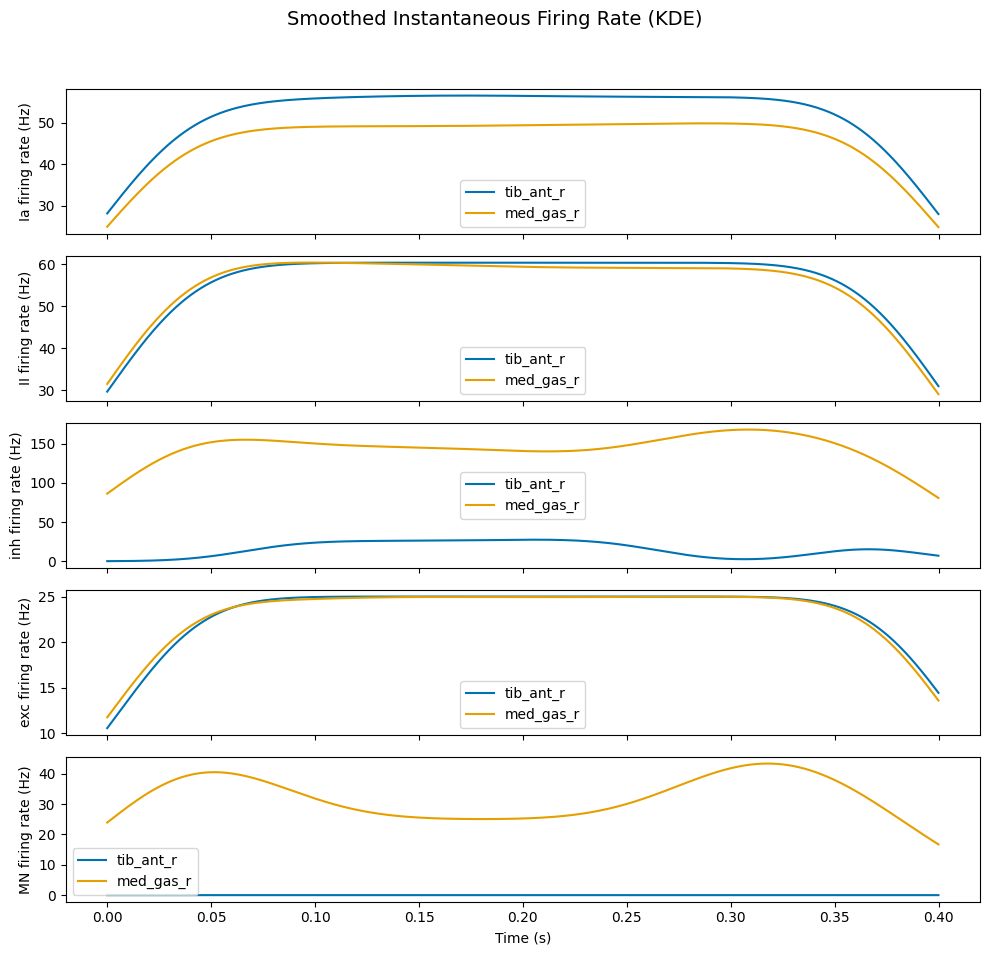

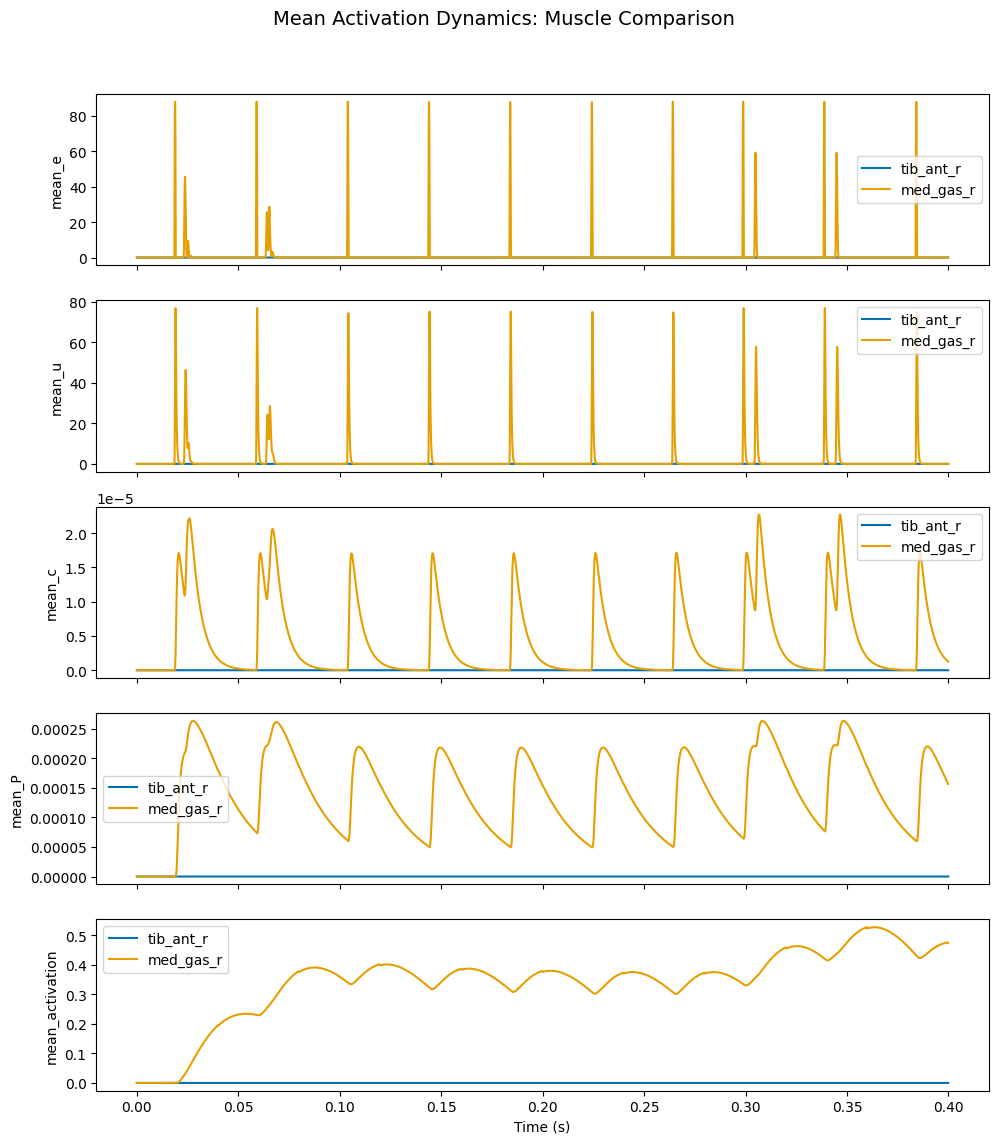

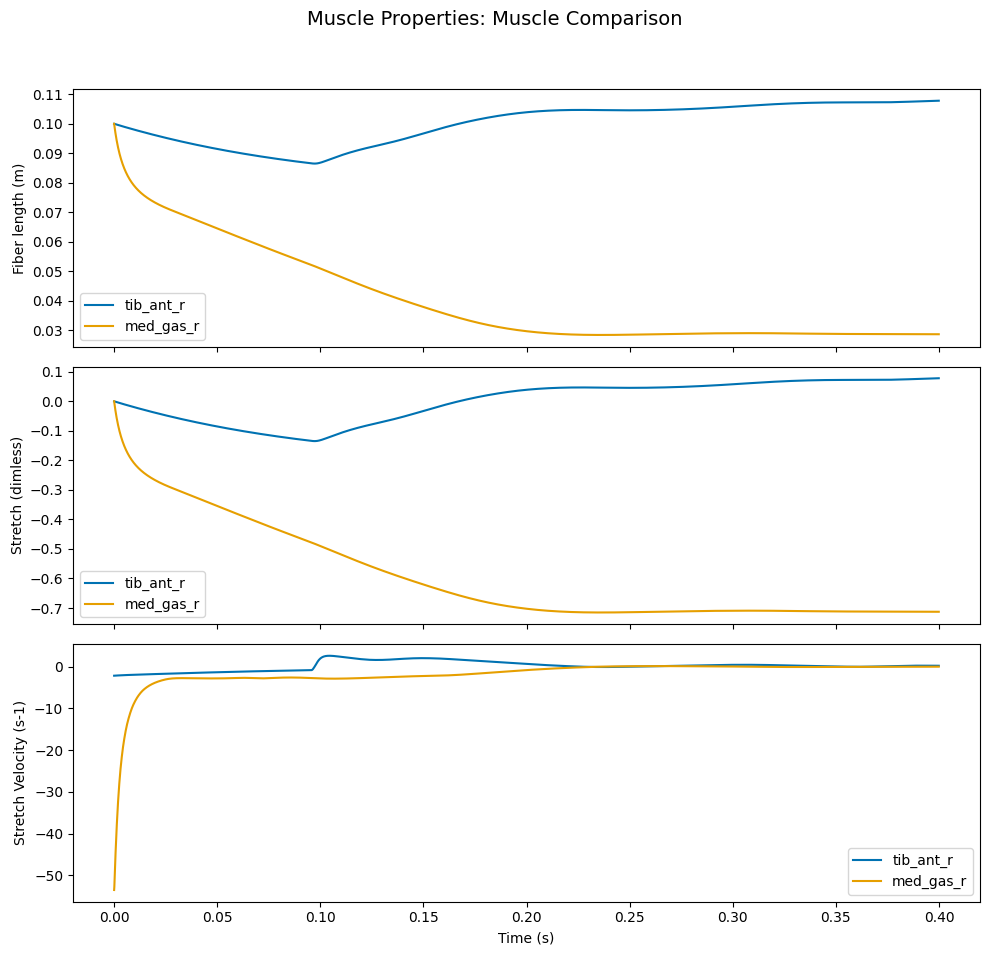

STDOUT:
 [info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
results/All_opensim_Ia_60_II_60_Moto_0_Freq_50. Hz.sto file is saved




TypeError: plot_act_length_from_sto_file() got an unexpected keyword argument 'Ia_recruited'

In [11]:
"""
Neuromuscular Simulation Pipeline

This script runs a neuromuscular simulation that integrates:
1. Neural spike generation
2. Spike-to-activation decoding
3. Muscle length/velocity simulation via OpenSim

The pipeline iteratively simulates neural activity and muscle dynamics,
passing information between these components to create a closed-loop system.
"""

# =============================================================================
# Configuration Parameters
# =============================================================================

# Time parameters
REACTION_TIME = 40 * ms  # Duration of each simulation iteration
NUM_ITERATIONS = 10      # Number of simulation iterations
TIME_STEP = 0.1 * ms     # Simulation time step

# Neural population parameters
NEURON_COUNTS = {
    "Ia": 60,       # Type Ia afferent neurons
    "II": 60,       # Type II afferent neurons
    "inh": 196,     # Inhibitory interneurons
    "exc": 196,     # Excitatory interneurons
    "motor": 169    # Motor neurons
}

# Electrical stimulation parameters
EES_PARAMS = {
    'ees_freq': 50 * hertz,      # Frequency of epidural electrical stimulation
    'Ia_recruited': 60,     # Number of Ia fibers recruited
    'II_recruited': 60,     # Number of II fibers recruited
    'eff_recruited': 0       # Number of efferent fibers recruited
}

# Neuron biophysical parameters
BIOPHYSICAL_PARAMS = {
    'T_refr': 2 * ms,  # Refractory period
    'Eleaky':-65*mV,
    'gL':10*nS,
    'Cm':0.3*nF,
    'E_ex':0*mV,
    'E_inh':-75*mV,
    'tau_exc':0.5*ms,
    'tau_1':5*ms,
    'tau_2':10*ms,
    'threshold_v':-55*mV
}

# Muscle configuration
MUSCLE_NAMES_STR = "tib_ant_r,med_gas_r"  # Comma-separated muscle names
MUSCLE_NAMES = MUSCLE_NAMES_STR.split(",")
NUM_MUSCLES = len(MUSCLE_NAMES)

# Validate muscle count
if NUM_MUSCLES > 2:
    raise ValueError("This pipeline supports only 1 or 2 muscles!")

# =============================================================================
# Initialization
# =============================================================================

# Initialize arrays to store muscle stretch and velocity
stretch = np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP)))
velocity = np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP)))
stretch0=stretch.copy()

initial_potentials=None
# Initialize decoder states for each motor neuron in each muscle
initial_decoder_states = [
    {i: {'u0': [0.0, 0.0], 'c0': [0.0, 0.0], 'P0': [0.0], 'a0': [0.0]}
     for i in range(NEURON_COUNTS["motor"])}
    for _ in range(NUM_MUSCLES)
]

# Containers for simulation data
muscle_data = [[] for _ in range(NUM_MUSCLES)]
resting_lengths = [None] * NUM_MUSCLES


# Structure to store spike data for all muscles and neuron types
spike_data = {
    muscle_name: {
        "Ia": defaultdict(list),
        "II": defaultdict(list),
        "inh": defaultdict(list),
        "exc": defaultdict(list),
        "MN": defaultdict(list)
    } for muscle_name in MUSCLE_NAMES
}

# Create results directory
RESULTS_DIR = 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Use temporary file for state management across iterations
state_file = None

# =============================================================================
# Main Simulation Loop
# =============================================================================


print("Start Simulation :")
print("EES frequency : " + str(EES_PARAMS['ees_freq']))
print("Number Ia fibers recruited by EES: " + str(EES_PARAMS['Ia_recruited'])+ " / "+str(NEURON_COUNTS['Ia']))
print("Number II fibers recruited by EES : " + str(EES_PARAMS['II_recruited'])+ " / "+str(NEURON_COUNTS['II']))
print("Number Efferent fibers recruited by EES : " + str(EES_PARAMS['eff_recruited'])+" / "+str(NEURON_COUNTS['motor']))

for iteration in range(NUM_ITERATIONS):
    print(f"--- Iteration {iteration+1} of {NUM_ITERATIONS} ---")

    # Run neural simulation based on muscle count
    if NUM_MUSCLES == 1:
        all_spikes, final_potentials = run_neural_simulations(
            stretch, velocity, NEURON_COUNTS, TIME_STEP, REACTION_TIME,initial_potentials
            **EES_PARAMS, **BIOPHYSICAL_PARAMS
        )
    else:  # NUM_MUSCLES == 2
        all_spikes,  final_potentials = run_flexor_extensor_neuron_simulation(
            stretch, velocity, NEURON_COUNTS, TIME_STEP, REACTION_TIME, initial_potentials,
            **EES_PARAMS, **BIOPHYSICAL_PARAMS
        )
    initial_potential=final_potentials
    # Store spike times for visualization
    for muscle_idx, muscle_name in enumerate(MUSCLE_NAMES):
        muscle_spikes = all_spikes[muscle_idx]
        for fiber_type, fiber_spikes in muscle_spikes.items():
            for neuron_id, spikes in fiber_spikes.items():
                # Adjust spike times by iteration offset
                adjusted_spikes = spikes/second + iteration * REACTION_TIME/second
                spike_data[muscle_name][fiber_type][neuron_id].extend(adjusted_spikes)

    # Initialize arrays for mean values of all neurons per muscle
    mean_e, mean_u, mean_c, mean_P, mean_activation = [
        np.zeros((NUM_MUSCLES, int(REACTION_TIME/TIME_STEP))) for _ in range(5)
    ]

    # Process motor neuron spikes to get muscle activations
    for muscle_idx, muscle_spikes in enumerate(all_spikes):
        # Only process if we have motor neuron spikes
        if len(muscle_spikes["MN"]) > 0:
            # Convert spike times to seconds
            mn_spikes_sec = [value/second for _, value in muscle_spikes["MN"].items()]

            # Decode spikes to muscle activations
            e, u, c, P, activations, final_values = decode_spikes_to_activation(
                mn_spikes_sec,
                TIME_STEP/second,
                REACTION_TIME/second,
                initial_decoder_states[muscle_idx]
            )

            # Store mean values across all neurons
            mean_e[muscle_idx] = np.mean(e, axis=0)
            mean_u[muscle_idx] = np.mean(u, axis=0)
            mean_c[muscle_idx] = np.mean(c, axis=0)
            mean_P[muscle_idx] = np.mean(P, axis=0)
            mean_activation[muscle_idx] = np.mean(activations, axis=0)

            # Save final state for next iteration
            initial_decoder_states[muscle_idx] = final_values

    # Run OpenSim muscle simulation using the computed activations
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_file, \
         tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_file, \
         tempfile.NamedTemporaryFile(suffix='.json', delete=False) as new_state_file:

        input_path = input_file.name
        output_path = output_file.name
        new_state_path = new_state_file.name

        # Save activations to temporary file
        np.save(input_path, mean_activation)

        # Build command for OpenSim muscle simulation
        cmd = [
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(TIME_STEP/second),
            '--T', str(REACTION_TIME/second),
            '--muscles', MUSCLE_NAMES_STR,
            '--activation', input_path,
            '--output_stretch', output_path,
            '--output_final_state', new_state_path
        ]

        # Add initial state parameter if not the first iteration
        if iteration > 0:
            cmd += ['--initial_state', state_file]

        # Run OpenSim simulation
        process = subprocess.run(cmd, capture_output=True, text=True)

        #if process.stdout.strip():
        #    print("STDOUT:\n", process.stdout)

        # Process OpenSim results
        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            # Load muscle lengths from simulation
            fiber_lengths = np.load(output_path)
            # Remove the last value as it will be included in the next iteration
            fiber_lengths = fiber_lengths[:, :-1]

            # Process each muscle's data
            for muscle_idx in range(NUM_MUSCLES):
                # Set resting length on first iteration
                if iteration == 0:
                    resting_lengths[muscle_idx] = fiber_lengths[muscle_idx, 0]

                # Calculate stretch and velocity for next iteration
                stretch[muscle_idx] = fiber_lengths[muscle_idx] / resting_lengths[muscle_idx] - 1
                time_points = np.arange(0, REACTION_TIME/second, TIME_STEP/second)
                velocity[muscle_idx] = np.gradient(stretch[muscle_idx], time_points)

                # Create batch data for current iteration
                batch_data = {
                    'mean_e': mean_e[muscle_idx],
                    'mean_u': mean_u[muscle_idx],
                    'mean_c': mean_c[muscle_idx],
                    'mean_P': mean_P[muscle_idx],
                    'mean_activation': mean_activation[muscle_idx],
                    'fiber_length': fiber_lengths[muscle_idx],
                    'stretch': stretch[muscle_idx],
                    'velocity': velocity[muscle_idx]
                }

                # Store batch data for this muscle
                muscle_data[muscle_idx].append(pd.DataFrame(batch_data))
        else:
            error_msg = f'Error in iteration {iteration+1}. STDERR: {process.stderr}'
            raise RuntimeError(error_msg)

        # Clean up the old state file if it exists
        if state_file is not None:
            os.unlink(state_file)

        # Update state file for next iteration
        state_file = new_state_path

        # Clean up other temporary files
        os.unlink(input_path)
        os.unlink(output_path)

# =============================================================================
# Save Results
# =============================================================================

# Combine muscle-specific data

muscle_dataframes = []

# Process and save data for each muscle
for muscle_idx, muscle_name in enumerate(MUSCLE_NAMES):

    # Combine all iteration data for this muscle
    combined_df = pd.concat(muscle_data[muscle_idx], ignore_index=True)

    # Add time column as first column
    combined_df['Time'] = np.arange(len(combined_df)) * (TIME_STEP/second)
    combined_df = combined_df[['Time'] + [col for col in combined_df.columns if col != 'Time']]

    # Store dataframe for plotting
    muscle_dataframes.append(combined_df)


# Save spike data
spikes_path = os.path.join(
    RESULTS_DIR,
    f'Spikes_Ia_{EES_PARAMS["Ia_recruited"]}_II_{EES_PARAMS["II_recruited"]}'
    f'eff_{EES_PARAMS["eff_recruited"]}_freq_{EES_PARAMS["ees_freq"]}.json'
)
with open(spikes_path, "w") as f:
    json.dump(spike_data, f, indent=4)
print(f"Saved: {spikes_path}")


# =============================================================================
# Generate Plots
# =============================================================================

# Generate time series plots
plot_times_series(stretch0,spike_data, muscle_dataframes, MUSCLE_NAMES, RESULTS_DIR, **EES_PARAMS)

# =============================================================================
# Run Complete Muscle Simulation
# =============================================================================

# Create full simulation STO file for visualization
complete_sto_name = f'All_opensim_' \
                   f'Ia_{EES_PARAMS["Ia_recruited"]}_' \
                   f'II_{EES_PARAMS["II_recruited"]}_' \
                   f'Moto_{EES_PARAMS["eff_recruited"]}_' \
                   f'Freq_{EES_PARAMS["ees_freq"]}.sto'
complete_sto_path = os.path.join(RESULTS_DIR, complete_sto_name)

# Create temporary file for activation data
with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_file:
    input_path = input_file.name

    # Save muscle activations without time column
    activations_array = np.zeros((NUM_MUSCLES, len((muscle_dataframes[0]))))
    for i in range(NUM_MUSCLES):
        activations_array[i]=muscle_dataframes[i]['mean_activation'].T.to_numpy()

    np.save(input_path, activations_array)


    # Build command for full muscle simulation
    cmd = [
        'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
        '--dt', str(TIME_STEP/second),
        '--T', str(REACTION_TIME/second * NUM_ITERATIONS),
        '--muscle', MUSCLE_NAMES_STR,
        '--activation', input_path,
        '--output_all', complete_sto_path
    ]

    # Run OpenSim simulation for complete trajectory
    process = subprocess.run(cmd, capture_output=True, text=True)

    if process.stdout.strip():
        print("STDOUT:\n", process.stdout)
    if process.stderr.strip():
        print(f"STDERR: {process.stderr}")

    # Clean up temporary file
    os.unlink(input_path)

# =============================================================================
# Joint Analysis
# =============================================================================

# Define joint angles of interest
JOINT_COLUMNS = [
    #"hip_flexion_r",
    #"hip_adduction_r",
    #"hip_rotation_r",
    "knee_angle_r",
    "ankle_angle_r",
]

# Generate plots for muscle activity and length
pal(complete_sto_path, MUSCLE_NAMES, RESULTS_DIR, **EES_PARAMS)

# Generate plots for joint angles
pja(complete_sto_path, JOINT_COLUMNS, RESULTS_DIR, **EES_PARAMS)

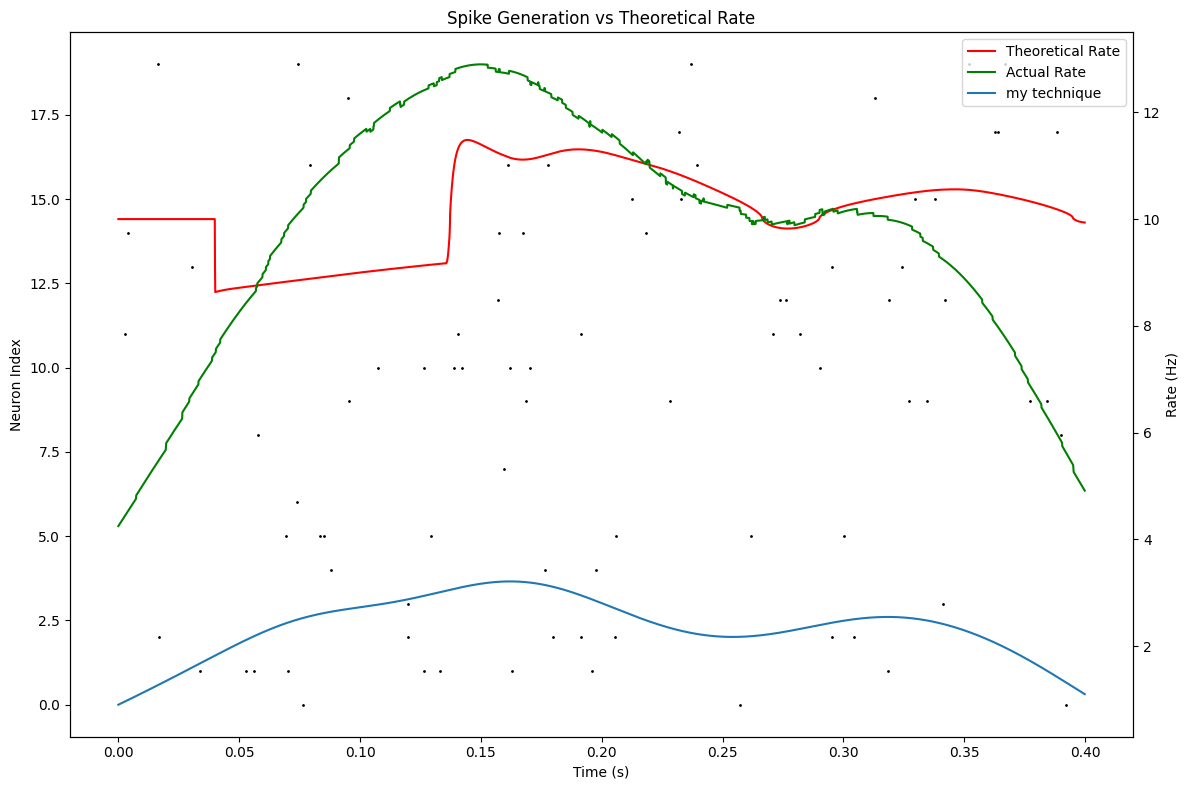

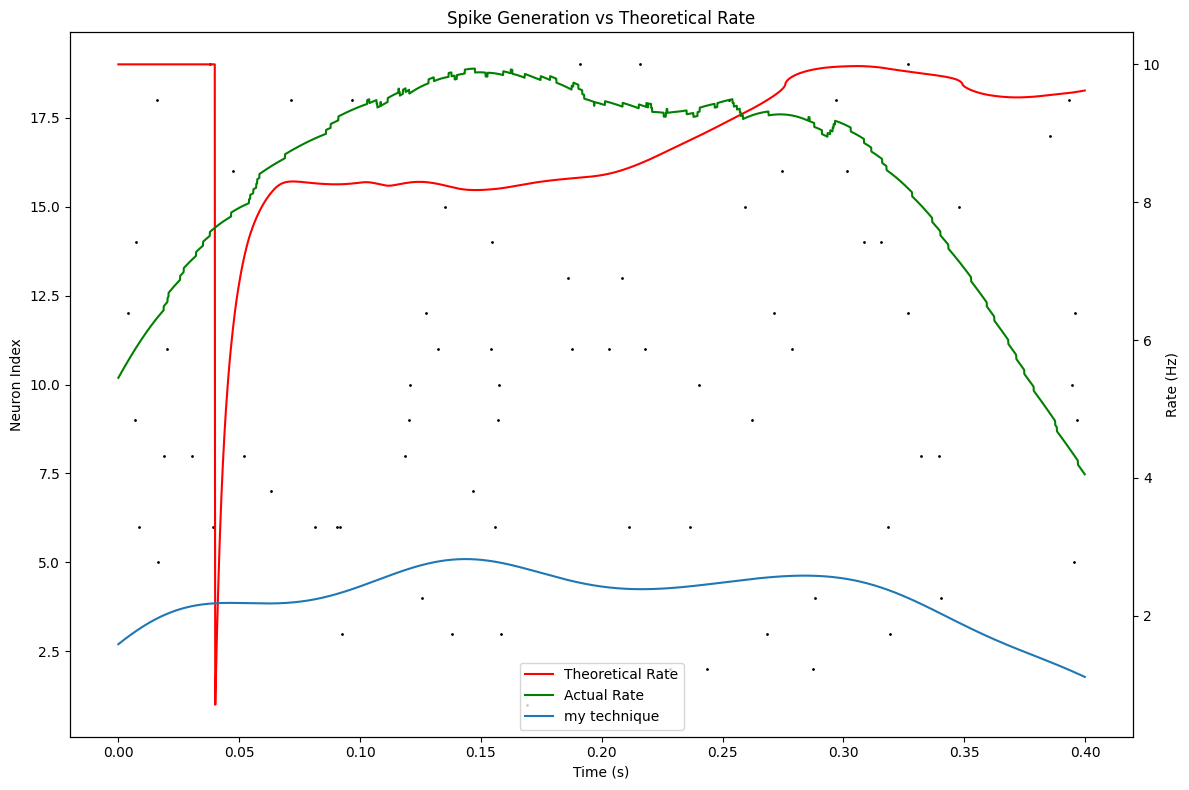

In [42]:
from scipy.stats import gaussian_kde
def verify_spike_rates(stretch, velocity, dt_run, duration):
    """Verify that the spike generation matches the calculated rates"""
    # Start a new scope
    start_scope()

    # Create TimedArrays
    stretch_array = TimedArray(stretch, dt=dt_run)
    velocity_array = TimedArray(velocity, dt=dt_run)

    # Create test neuron equations
    test_eq = '''
    stretch = stretch_array(t) : 1
    velocity = velocity_array(t) : 1
    rate = 10*Hz + 0.4*Hz*stretch + 0.86*Hz*sign(velocity)*abs(velocity)**0.6 : Hz
    '''

    # Create neurons and spike monitor
    T_refr = 1*ms  # Default refractory period
    test_neurons = NeuronGroup(20, test_eq, threshold='rand() < rate*dt', refractory=T_refr, method='euler')
    spike_mon = SpikeMonitor(test_neurons)
    rate_mon = PopulationRateMonitor(test_neurons)

    # Run simulation
    run(duration)

    # Calculate the theoretical rate over time
    time_steps = int(duration / dt_run)
    theoretical_rate = np.zeros(time_steps)
    for i in range(time_steps):
        s = stretch[i]
        v = velocity[i]
        theoretical_rate[i] = 10 + 0.4*s + 0.86*np.sign(v)*np.abs(v)**0.6

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot spikes
    ax.plot(spike_mon.t/second, spike_mon.i, '.k', markersize=2)

    # Add a new y-axis for the rate
    ax2 = ax.twinx()
    ax2.plot(np.arange(0, duration, dt_run), theoretical_rate, 'r-', label='Theoretical Rate')
    ax2.plot(rate_mon.t/second, rate_mon.smooth_rate(width=50*ms)/Hz, 'g-', label='Actual Rate')

    all_spike_times = np.concatenate(list(spike_mon.spike_trains().values()))
    if len(all_spike_times)>1:
        kde = gaussian_kde(all_spike_times, bw_method=0.3)
        firing_rate = kde(np.arange(0, duration, dt_run))
        ax2.plot(np.arange(0, duration, dt_run), firing_rate, label="my technique")
    else:
        ax2.plot(np.arange(0, duration, dt_run), np.zeros_like(np.arange(0, duration, dt_run)), label="my technique")
        ax2.set_ylabel(f'{fiber_type} firing rate (Hz)')
        ax2.legend()


    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron Index')
    ax2.set_ylabel('Rate (Hz)')
    ax2.legend()

    plt.title('Spike Generation vs Theoretical Rate')
    plt.tight_layout()


for i,muscle in enumerate(MUSCLE_NAMES):
    time = muscle_dataframes[i]['Time'].values
    stretch_init = np.append(stretch0[i], muscle_dataframes[i]['stretch'].values)
    stretch_init = stretch_init[:len(muscle_dataframes[i])]
    velocity_init = np.gradient(stretch_init, time)
    verify_spike_rates(stretch_init, velocity_init, TIME_STEP, REACTION_TIME*NUM_ITERATIONS)

Velocity values and corresponding power law results:
Velocity: -1.00, Result: -1.000000
Velocity: -0.50, Result: -0.659754
Velocity: -0.10, Result: -0.251189
Velocity: -0.01, Result: -0.063096
Velocity: 0.00, Result: 0.000000
Velocity: 0.01, Result: 0.063096
Velocity: 0.10, Result: 0.251189
Velocity: 0.50, Result: 0.659754
Velocity: 1.00, Result: 1.000000


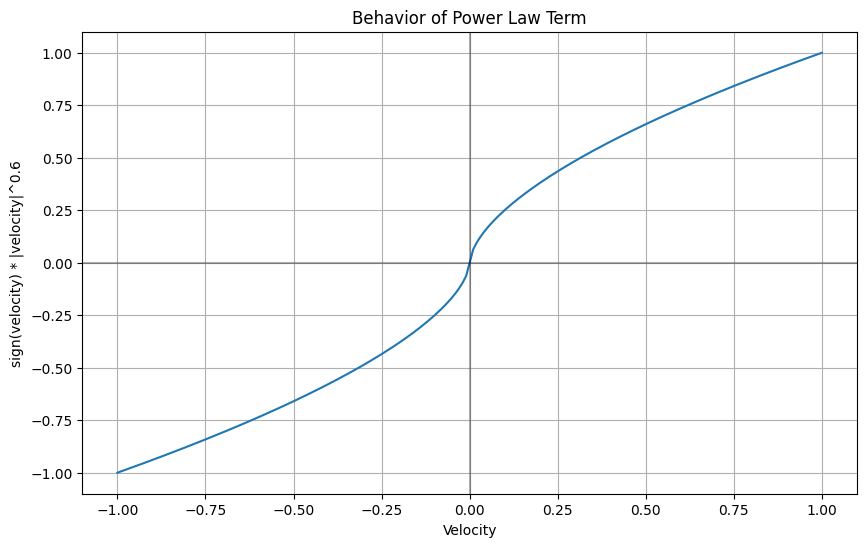

In [22]:
def check_power_law():
    """Check the behavior of the power law term in the rate equation"""
    velocity = np.linspace(-1, 1, 201)

    # Calculate the power law term
    power_law = np.sign(velocity) * np.abs(velocity)**0.6

    plt.figure(figsize=(10, 6))
    plt.plot(velocity, power_law)
    plt.grid(True)
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Velocity')
    plt.ylabel('sign(velocity) * |velocity|^0.6')
    plt.title('Behavior of Power Law Term')

    # Check specific values
    test_values = [-1, -0.5, -0.1, -0.01, 0, 0.01, 0.1, 0.5, 1]
    results = [np.sign(v) * np.abs(v)**0.6 for v in test_values]

    print("Velocity values and corresponding power law results:")
    for v, r in zip(test_values, results):
        print(f"Velocity: {v:.2f}, Result: {r:.6f}")

check_power_law()

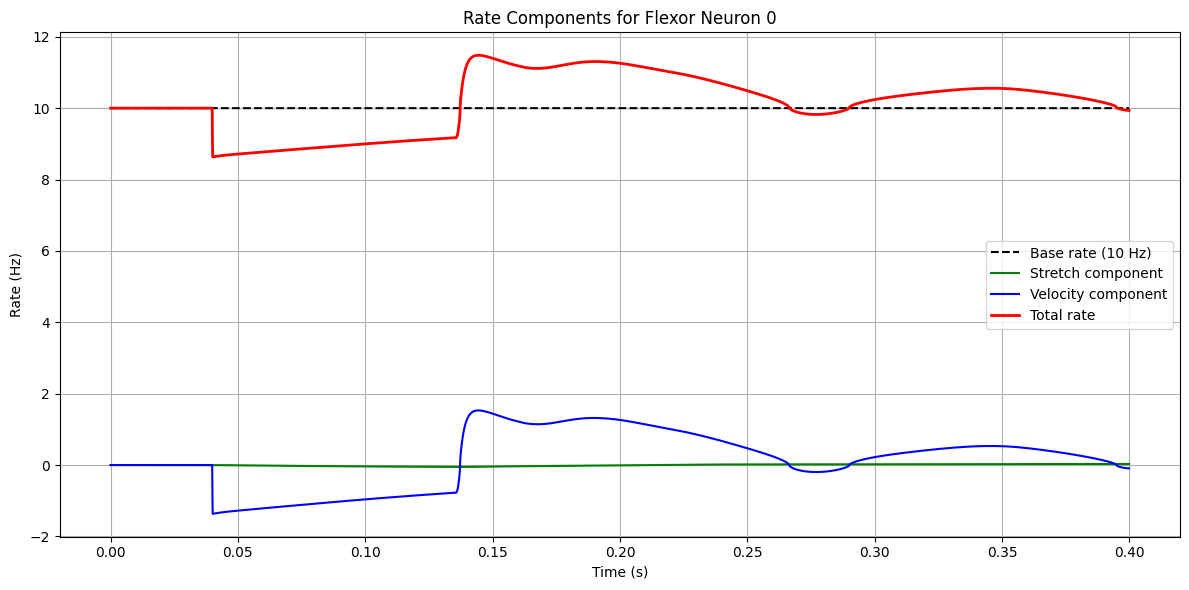

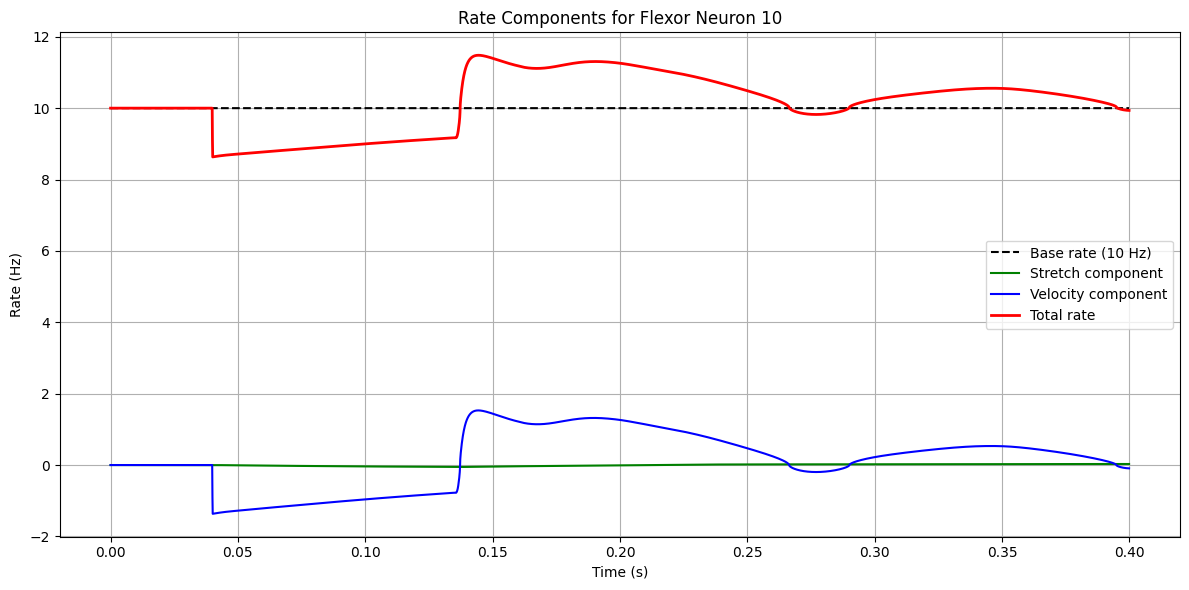

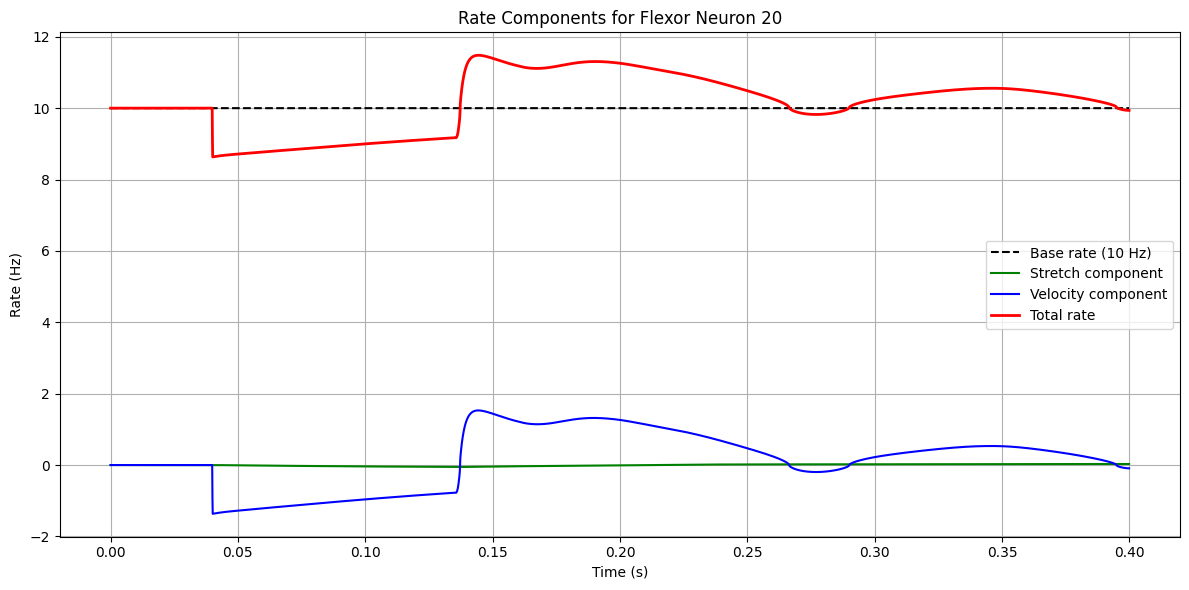

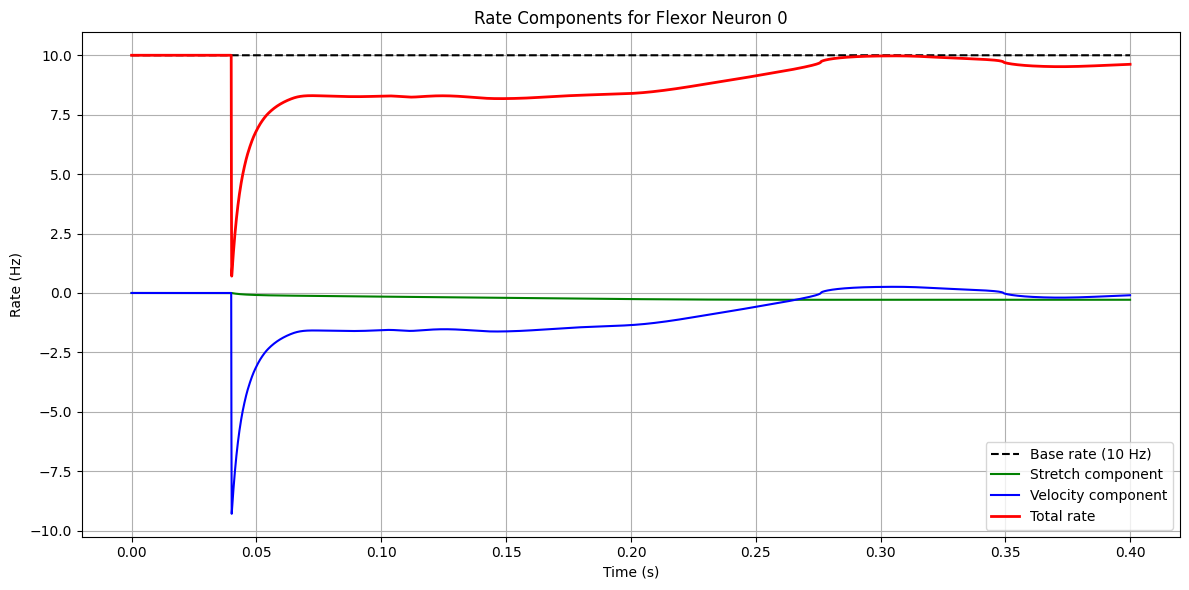

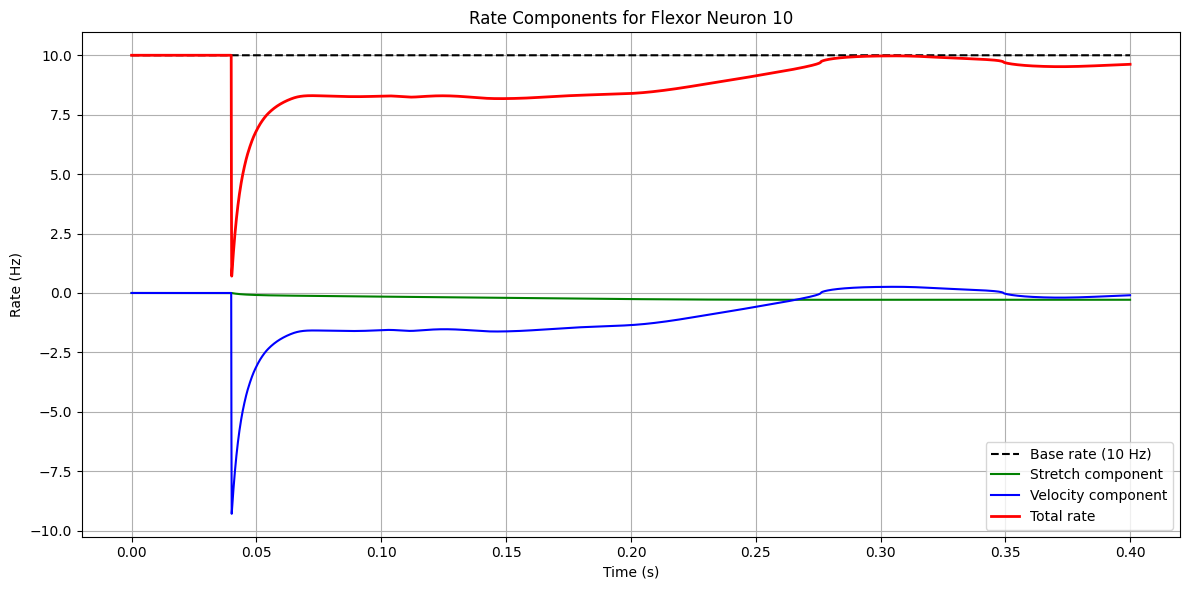

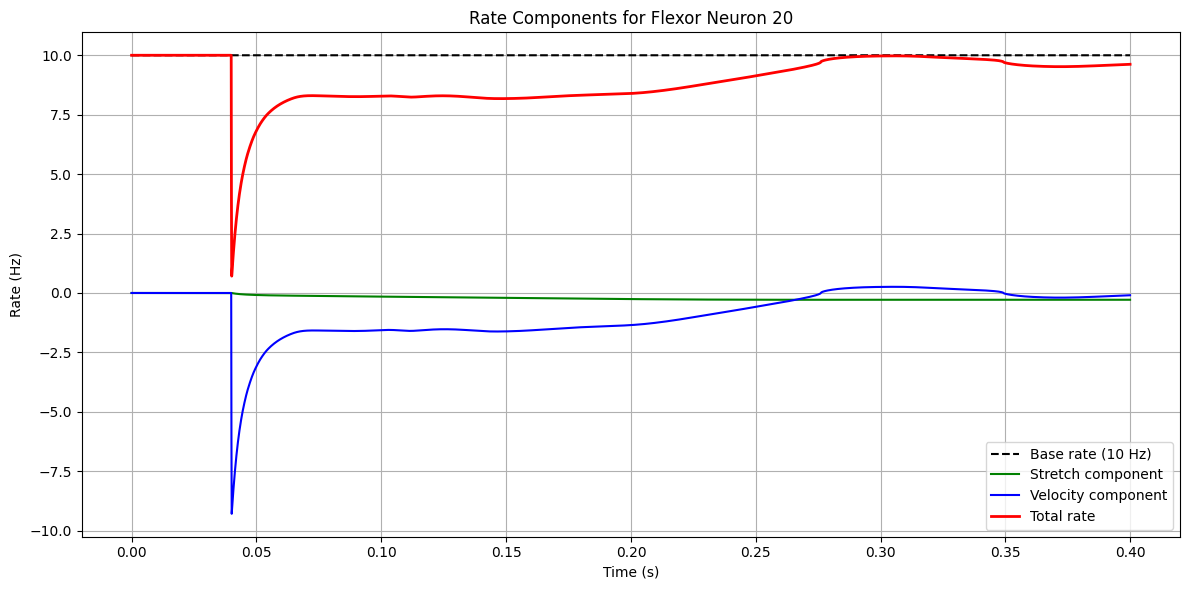

In [25]:
def analyze_rate_components(stretch, velocity, dt_run, duration, neuron_indices=[0, 10, 20]):
    """Analyze the components of the rate calculation for specific neurons"""
    time = np.arange(0, duration, dt_run)

    for neuron_idx in neuron_indices:
        # Determine if flexor or extensor
        is_flexor = neuron_idx < 60

        # Get appropriate stretch and velocity arrays
        s_array = stretch
        v_array = velocity

        # Calculate components
        base_rate = np.ones_like(time) * 10  # Base rate of 10 Hz
        stretch_component = 0.4 * s_array
        velocity_component = 0.86 * np.sign(v_array) * np.abs(v_array)**0.6
        total_rate = base_rate + stretch_component + velocity_component

        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(time, base_rate, 'k--', label='Base rate (10 Hz)')
        ax.plot(time, stretch_component, 'g-', label='Stretch component')
        ax.plot(time, velocity_component, 'b-', label='Velocity component')
        ax.plot(time, total_rate, 'r-', linewidth=2, label='Total rate')

        ax.set_title(f'Rate Components for {"Flexor" if is_flexor else "Extensor"} Neuron {neuron_idx}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Rate (Hz)')
        ax.legend()
        plt.grid(True)
        plt.tight_layout()

for i,muscle in enumerate(MUSCLE_NAMES):
    time = muscle_dataframes[i]['Time'].values
    stretch_init = np.append(stretch0[i], muscle_dataframes[i]['stretch'].values)
    stretch_init = stretch_init[:len(muscle_dataframes[i])]
    velocity_init = np.gradient(stretch_init, time)
    analyze_rate_components(stretch_init, velocity_init, TIME_STEP, REACTION_TIME*NUM_ITERATIONS, neuron_indices=[0, 10, 20])


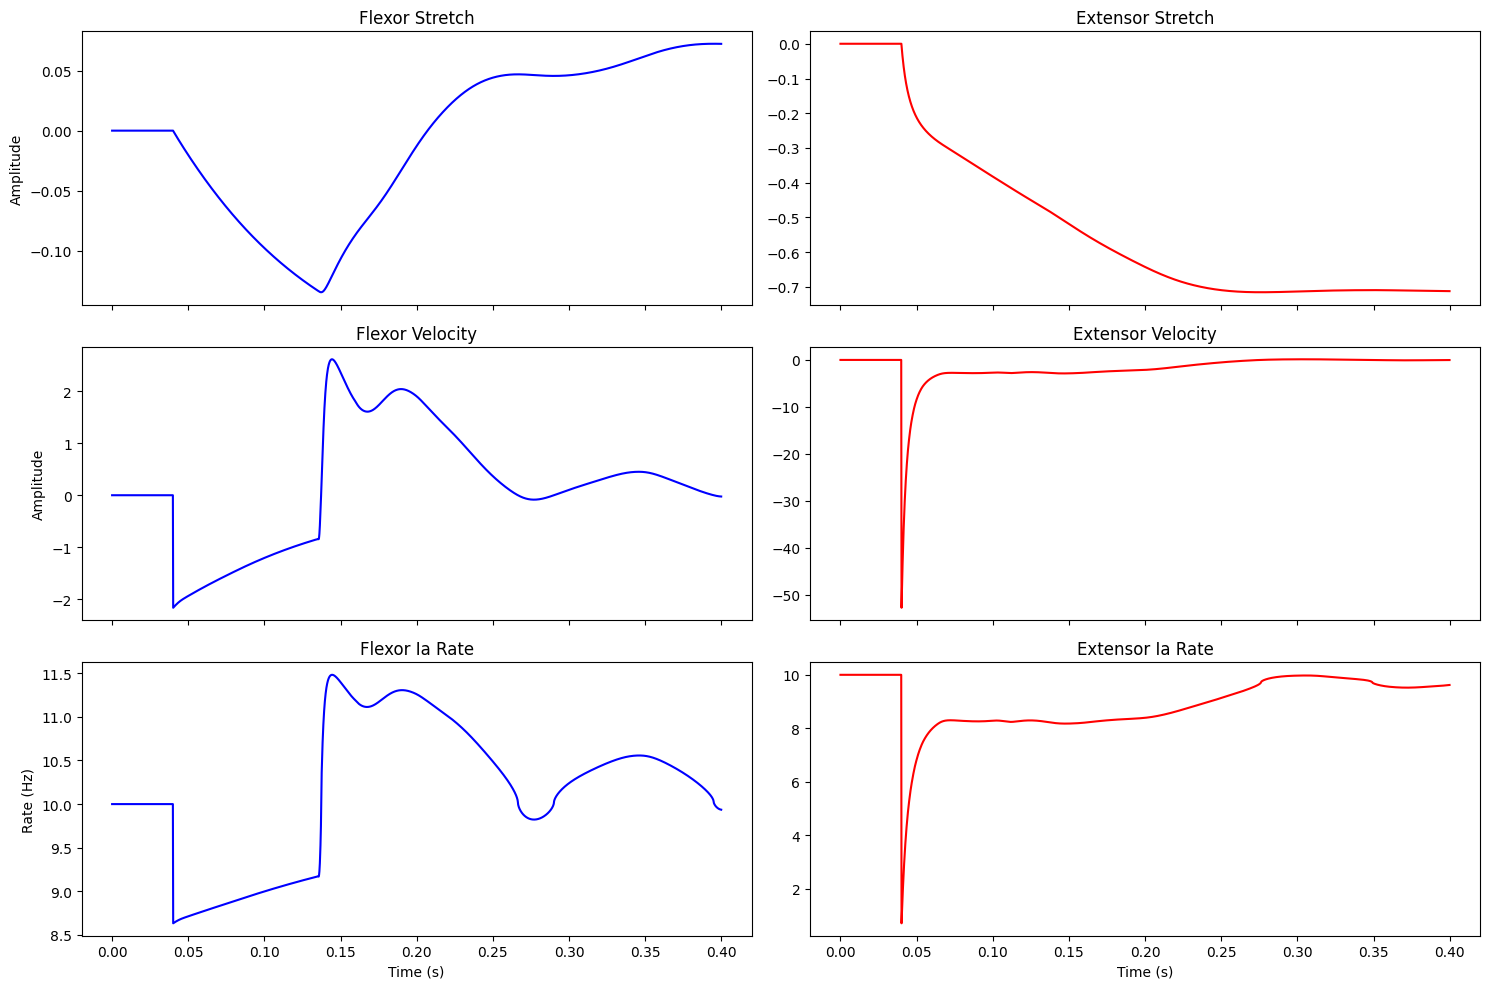

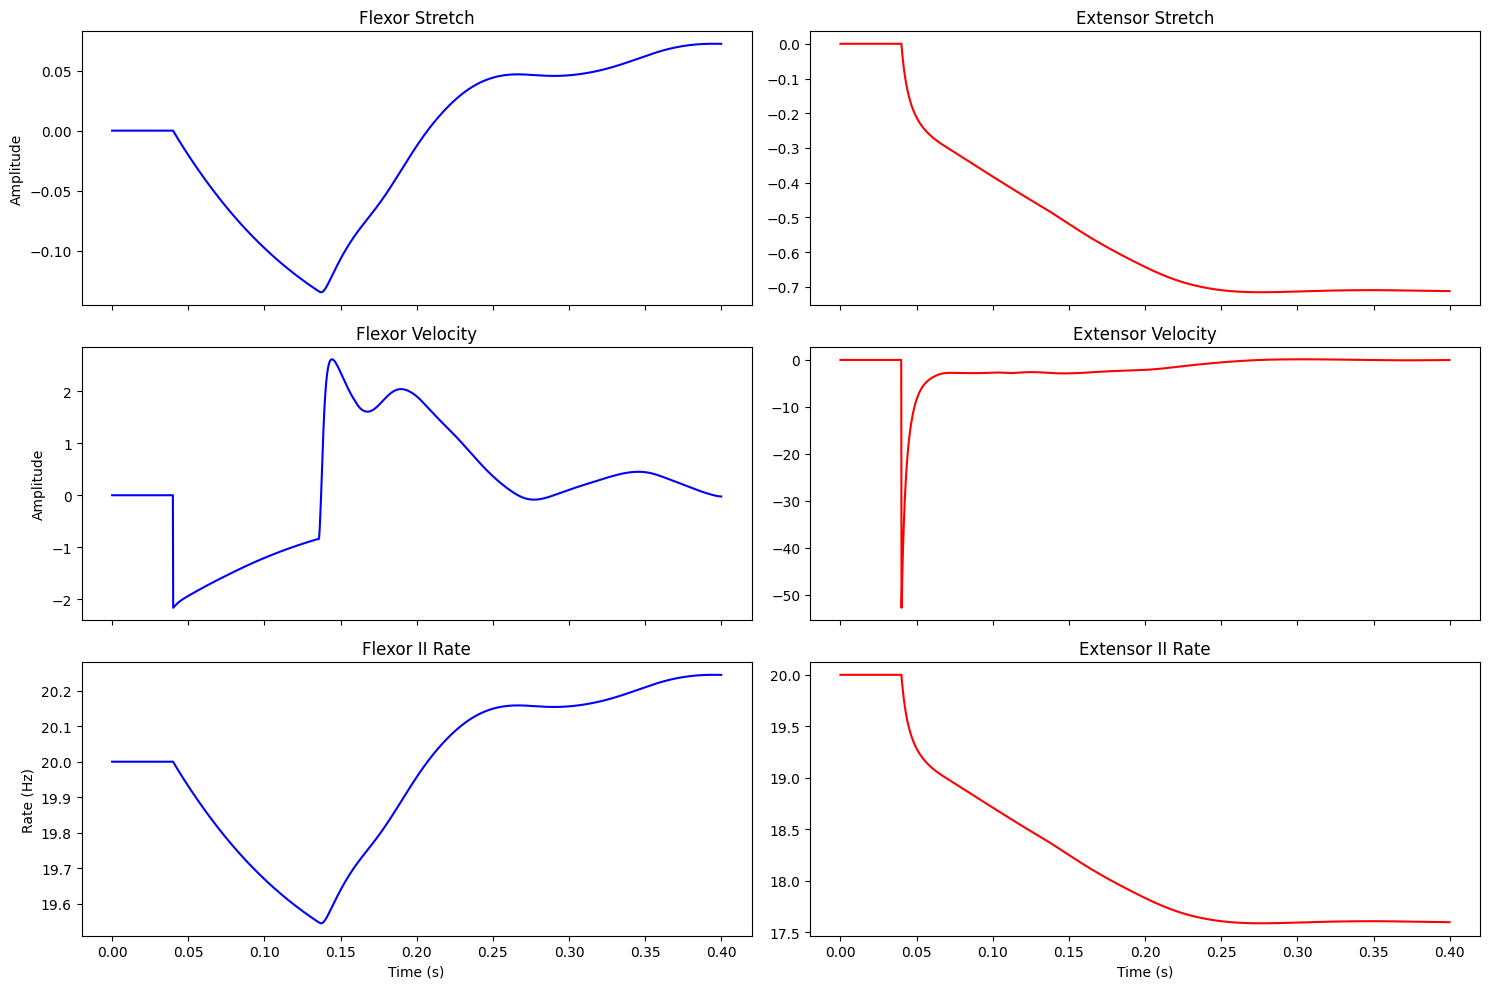

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *

# Function to simulate and plot the rates
def plot_rate_components(stretch, velocity, dt_run, duration, neuron_type='Ia'):
    # Create time array
    time = np.arange(0, duration, dt_run)

    # Initialize arrays for calculated rates
    rates_flexor = np.zeros_like(time)
    rates_extensor = np.zeros_like(time)

    # Calculate rate components for each time step
    for i, t in enumerate(time):
        # Flexor
        s_flex = stretch[0][i]
        v_flex = velocity[0][i]

        # Extensor
        s_ext = stretch[1][i]
        v_ext = velocity[1][i]

        if neuron_type == 'Ia':
            # Ia neuron rate calculations
            rate_flex = 10 + 0.4*s_flex + 0.86*np.sign(v_flex)*abs(v_flex)**0.6
            rate_ext = 10 + 0.4*s_ext + 0.86*np.sign(v_ext)*abs(v_ext)**0.6
        else:
            # II neuron rate calculations
            rate_flex = 20 + 3.375*s_flex
            rate_ext = 20 + 3.375*s_ext

        rates_flexor[i] = rate_flex
        rates_extensor[i] = rate_ext

    # Create figure for plotting
    fig, axes = plt.subplots(3, 2, figsize=(15, 10), sharex=True)

    # Plot stretch
    axes[0, 0].plot(time, stretch[0], 'b-')
    axes[0, 0].set_title('Flexor Stretch')
    axes[0, 0].set_ylabel('Amplitude')

    axes[0, 1].plot(time, stretch[1], 'r-')
    axes[0, 1].set_title('Extensor Stretch')

    # Plot velocity
    axes[1, 0].plot(time, velocity[0], 'b-')
    axes[1, 0].set_title('Flexor Velocity')
    axes[1, 0].set_ylabel('Amplitude')

    axes[1, 1].plot(time, velocity[1], 'r-')
    axes[1, 1].set_title('Extensor Velocity')

    # Plot rate
    axes[2, 0].plot(time, rates_flexor, 'b-')
    axes[2, 0].set_title(f'Flexor {neuron_type} Rate')
    axes[2, 0].set_ylabel('Rate (Hz)')
    axes[2, 0].set_xlabel('Time (s)')

    axes[2, 1].plot(time, rates_extensor, 'r-')
    axes[2, 1].set_title(f'Extensor {neuron_type} Rate')
    axes[2, 1].set_xlabel('Time (s)')

    plt.tight_layout()
    return fig, rates_flexor, rates_extensor

# Call the function for Ia neurons
fig_ia, rates_ia_flex, rates_ia_ext = plot_rate_components(stretch, velocity, TIME_STEP, REACTION_TIME*NUM_ITERATIONS, 'Ia')

# Call the function for II neurons
fig_ii, rates_ii_flex, rates_ii_ext = plot_rate_components(stretch, velocity, TIME_STEP, REACTION_TIME*NUM_ITERATIONS, 'II')